The aim of this project is to analyse the data in the chinook database and answer a series of relates business case questions.

The chinook database comprises of several tables and each contains a different type of data relevant to a fictional online music selling business.

We need to determine exactly what tables are included in the database as we will need this information to answer the business questions. Let's set up below and then run the queries necessary to obtain this information.

In [150]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command():
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
get_tables_and_views = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    """

run_query(get_tables_and_views)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


And thus we can see the various tables in the database.

Business query 1:

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

- Artist Name:	Genre
- Regal:	Hip-Hop
- Red Tone:	Punk
- Meteor and the Girls:	Pop
- Slim Jim Bites:	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [151]:
sales_per_genre_usa="""
WITH
sales_usa AS
    (SELECT il.* FROM invoice_line il 
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country ="USA")

SELECT
g.name genre,
SUM(su.quantity) tracks_sold,
ROUND(CAST(SUM(su.quantity) AS FLOAT) / (SELECT COUNT(*) FROM sales_usa) * 100, 2) percentage_sales
FROM sales_usa su 
INNER JOIN track t ON t.track_id = su.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre

"""

run_query(sales_per_genre_usa)

,genre,tracks_sold,percentage_sales
0,Alternative,35,3.33
1,Alternative & Punk,130,12.37
2,Blues,36,3.43
3,Classical,4,0.38
4,Easy Listening,13,1.24
5,Electronica/Dance,5,0.48
6,Heavy Metal,3,0.29
7,Hip Hop/Rap,20,1.90
8,Jazz,14,1.33
9,Latin,22,2.09


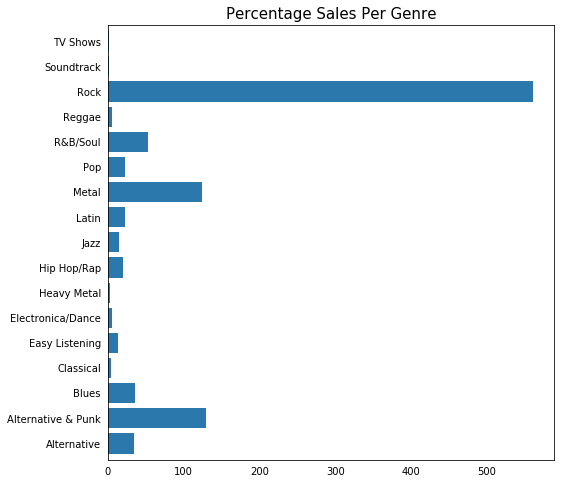

In [152]:
chart_data = run_query(sales_per_genre_usa)

chart = chart_data.plot(x="genre",
                y="tracks_sold",
                kind="barh",
                width=0.8,
               figsize=(8,8),
               legend=None,
               color=(43/255, 120/255, 173/255))

chart.set_ylabel(None)
chart.set_title("Percentage Sales Per Genre", fontsize=15)
chart.tick_params(
    left=False,
    bottom=False)

Of the 4 new artists:

- Artist Name:	Genre
- Regal:	Hip-Hop
- Red Tone:	Punk
- Meteor and the Girls:	Pop
- Slim Jim Bites:	Blues

Their genres rank as follows based on relative sales in the US:

- 1st: Alternative & Punk - 12.37%
- 2nd: Blues - 3.43%
- 3rd: Pop - 2.09%
- 4th: Hip-Hop/Rap - 1.9%

It should be noted, however, that the category Alternative and Punk contains what some would call two different but similar genres. We cannot determine the relative shares of Alternative and Punk from our data.

What should also be noted is the high popularities of Rock and Metal. This could be taken into account by chinook in the future.

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis. 

In [153]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price) / count(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

sales_by_country = run_query(sales_by_country)

sales_by_country

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

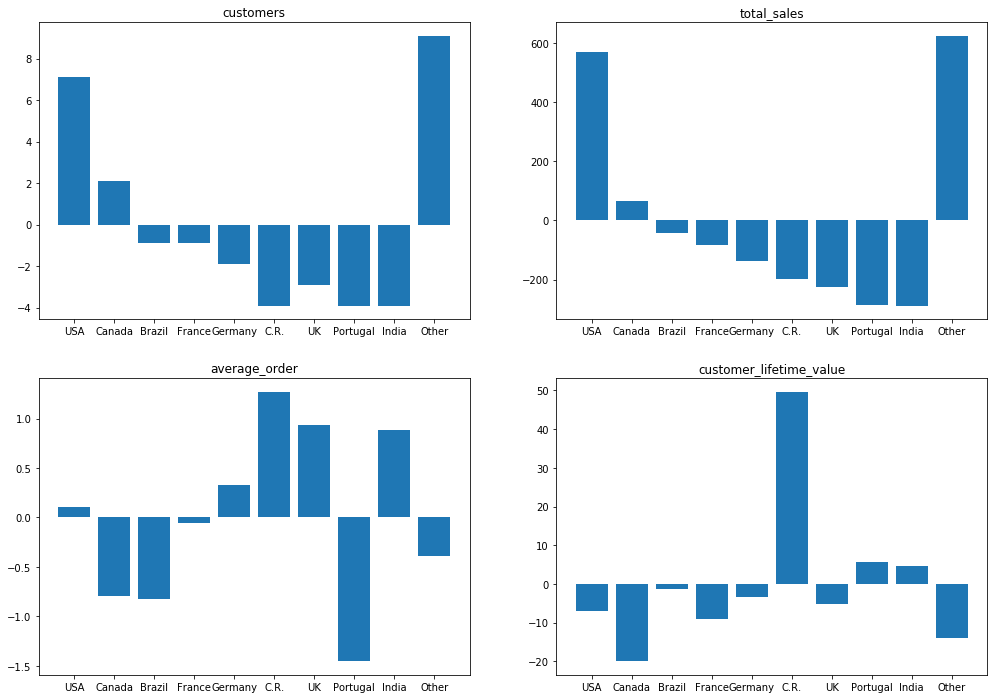

In [154]:
fig = plt.figure(figsize=(17,12))

n=1
sales_by_country.loc[6,"country"] = "UK"
sales_by_country.loc[5,"country"] = "C.R."

averages = {}

for c in sales_by_country.columns[1:]:
    averages[c] = sum(sales_by_country[c]) / sales_by_country[c].count()
    ax = fig.add_subplot(2,2,n)
    ax.bar(x=sales_by_country["country"], height=sales_by_country[c] - averages[c])
    ax.set_title(c)
    n += 1


From the visualisation and dataframe we can see:

- The USA and Canada have the highest number of customers at 13 and 8 respectively and a total of 15 countries olny have one chinook customer each.
- Total sales are generally in line with number of customers indicating that in general all customers spend relativly the same amount.
- Average value per order is lowest in Portugal (6.38) and highest in the Czeck Republic (9.1)
- Customer lifetime value is highest in the Czeck Republic

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [198]:
invoice_album_or_not = """


WITH combined_tables AS
    (SELECT *
    FROM invoice i 
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN 
        (
        SELECT 
            a.album_id alb_id,
            SUM(a.album_id) album_sum_2
        FROM album a INNER JOIN track t ON t.album_id = a.album_id
        GROUP BY alb_id
        ) s 
    ON s.alb_id = a.album_id)
SELECT         
    invoice_id,
    SUM(album_id) album_sum_1,
    album_id,
    album_sum_2,
    CASE
        WHEN SUM(album_id) = album_sum_2 THEN "album"
        ELSE "seperate"
        END AS album_or_seperate
FROM combined_tables
GROUP BY invoice_id
ORDER BY invoice_id
"""

album_and_seperate = run_query(invoice_album_or_not)

In [200]:
album_and_seperate["album_or_seperate"].value_counts()

seperate    500
album       114
Name: album_or_seperate, dtype: int64

In [206]:
print(f"Percentage of invoices for seperate songs: {round(500/614,2)*100}")
print(f"Percentage of invoices for full albums: {round(114/614,2)*100}")

Percentage of invoices for seperate songs: 81.0
Percentage of invoices for full albums: 19.0


Thus 19% of purchases are for full albums while 81% are for bundles of songs from one or more invoices.